# Multilabel classification model

**Imports and random seeds**

In [9]:
# Imports

import numpy as np
import pandas as pd
import torch

import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

import os


In [10]:
# Seeds

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


**Multilabel classification model**

In [11]:
class MultilabelClassificationModel():

    def __init__(self, variant):

        set_seed(42)
        self.all_features = ["darker", "gradient", "reddish", "metallic", "colorful", "black", "black_thin", "dominating_color", "color_bin_1", 
                             "color_bin_2", "color_bin_3", "color_bin_4", "color_bin_5", "color_bin_6", "color_bin_7", "color_bin_8", "color_bin_9", 
                             "color_entropy", "rough", "dominating_texture", "texture_0", "texture_1", "texture_2", "texture_3", "texture_4", 
                             "texture_5", "texture_6", "texture_7", "texture_8", "texture_9", "rough_entropy", "lengthy", "number_lengthy_objects", 
                             "lengthy_aspect_ratio", "rel_length", "in_shape", "roundness", "hu_moment_1", "hu_moment_2", "hu_moment_3", 
                             "hu_moment_4", "hu_moment_5", "hu_moment_6", "hu_moment_7"]
        
        self.focus_defects = ["Rust", "Drainage", "Graffiti", "ExposedRebars", "Wetspot", "Crack"]
        self.variant = variant
        
        self.dataset = self.load_dataset("../dataset/train_0_6935_all_defects.csv")
        self.dataset_train, _ = self.create_train_test_data(self.dataset)
        self.dataset_test = self.load_dataset("../dataset/validation_0_975_all_defects.csv")
        self.classifier = self.initialize_tree()
        self.y_pred, self.y_test = self.predict()
        
    def load_dataset(self, path):

        dataset = pd.read_csv(path, sep = ",")
        dataset.drop(columns = ["Unnamed: 0", "image_number", "defect_number"], inplace = True)
        dataset.dropna(inplace = True)
        dataset = dataset.sample(frac=1)

        return dataset
    
    def select_features(self, features, x):

        x = x.loc[:, features]

        return x
    
    def create_train_test_data(self, dataset):

        # Train test split
        split = int(0.7 * len(dataset))
        dataset_train = dataset.iloc[:split, :]
        dataset_test = dataset.iloc[split:, :]

        return dataset_train, dataset_test
    
    def create_labelled_data(self, df, balanced_sampling=True):

        df = df.copy()

        # Optionally replace non-focus defects by "Nothing":
        if self.variant == "focus":
            df['label'] = df['label'].apply(lambda x: x if x in self.focus_defects else 'Nothing')

        # Balanced sampling
        if balanced_sampling == True: 
            min_count = df["label"].value_counts().min()
            df = df.groupby("label").sample(n=min_count, random_state=42)

        # Create x and y data:
        df = df.copy()
        x = df.loc[:, self.all_features]
        y = df.loc[:, "label"]

        return x, y
    
    def initialize_tree(self):

        # Create dataset with labels:
        x_train, y_train = self.create_labelled_data(self.dataset_train)

        # Generate train dataset with selected features: 
        x_train = self.select_features(self.all_features, x_train)

        # Train random forest classifier:
        clf = RandomForestClassifier(n_estimators=50, criterion= "entropy", random_state=1, max_depth=10)
        clf.fit(x_train, y_train)

        return clf
    
    def predict(self):

        # Create dataset with labels:
        x_test, y_test = self.create_labelled_data(self.dataset_test, balanced_sampling=False)
        x_test = self.select_features(self.all_features, x_test)
        y_pred = self.classifier.predict(x_test)

        return y_pred, y_test
    
    def evaluate_results(self):

        y_pred, y_true = self.y_pred, self.y_test

        accuracy = accuracy_score(y_true, y_pred)
        
        recall_micro = recall_score(y_true, y_pred, average='micro')
        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_weighted = recall_score(y_true, y_pred, average='weighted')

        f1_micro = f1_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

        # Save results:
        df = pd.DataFrame({"Accuracy": [accuracy], "Recall (Micro)": [recall_micro], "Recall (Macro)": [recall_macro], 
                           "Recall (Weighted)": [recall_weighted], "F1 Score (Micro)": [f1_micro], "F1 Score (Macro)": [f1_macro], 
                           "F1 Score (Weighted)": [f1_weighted]})
        os.makedirs(os.path.dirname(f"results/results_multilabel_classification_{self.variant}.csv"), exist_ok=True)
        df.to_csv(f"results/results_cross_classification_{self.variant}.csv")
        print(f'Accuracy: {accuracy}')
        print(f'Recall (Micro): {recall_micro}')
        print(f'Recall (Macro): {recall_macro}')
        print(f'Recall (Weighted): {recall_weighted}')
        print(f'F1 Score (Micro): {f1_micro}')
        print(f'F1 Score (Macro): {f1_macro}')
        print(f'F1 Score (Weighted): {f1_weighted}')

        cm = confusion_matrix(y_true, y_pred, labels = sorted(list(set(y_true))))
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

        # Compute confusion matrix
        labels = sorted(list(set(y_true)))

        # Plotting the confusion matrix as a heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')

        # Save the plot
        os.makedirs(os.path.dirname(f"results/results_multilabel_classification_{self.variant}.png"), exist_ok=True)
        plt.savefig(f"results/results_multilabel_classification_{self.variant}.png")
        plt.show()

# Multilabel classification evaluation

**Multilabel classification evaluation using only focus features**

Accuracy: 0.32533365985061835
Recall (Micro): 0.32533365985061835
Recall (Macro): 0.5009755804167985
Recall (Weighted): 0.32533365985061835
F1 Score (Micro): 0.32533365985061835
F1 Score (Macro): 0.287610133624586
F1 Score (Weighted): 0.36098059655818737


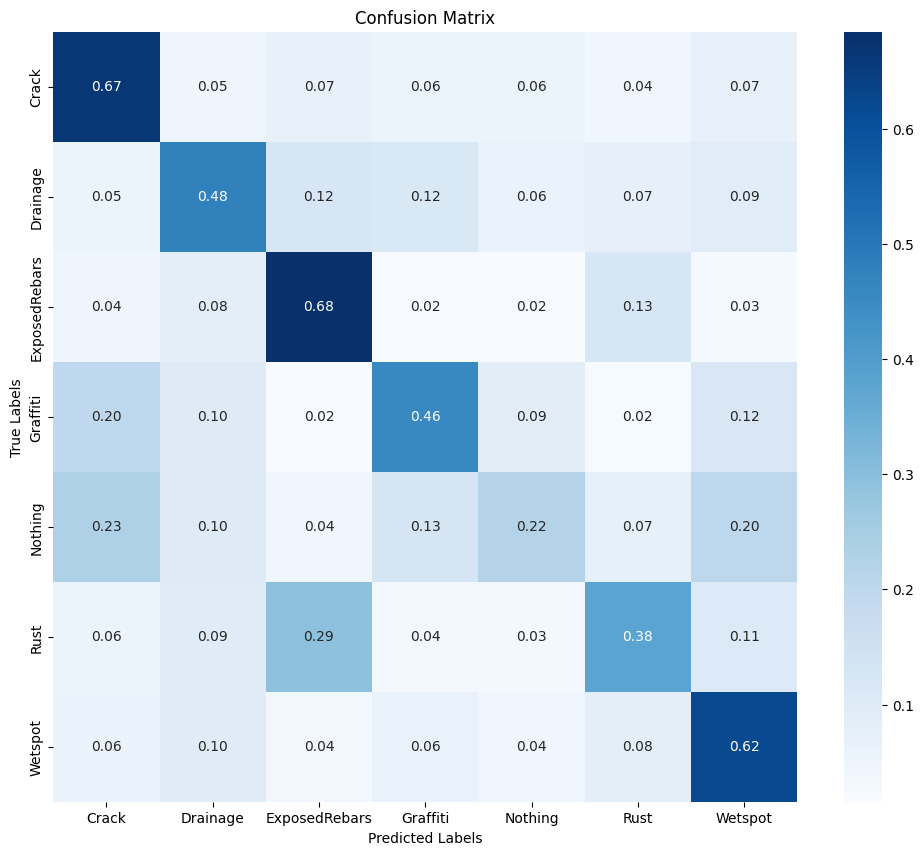

In [12]:
multilabel_classification = MultilabelClassificationModel("focus").evaluate_results()


**Multilabel classification evaluation using all features**

Accuracy: 0.3085588343332925
Recall (Micro): 0.3085588343332925
Recall (Macro): 0.30551920823920886
Recall (Weighted): 0.3085588343332925
F1 Score (Micro): 0.3085588343332925
F1 Score (Macro): 0.23253071036443726
F1 Score (Weighted): 0.3142879817663622


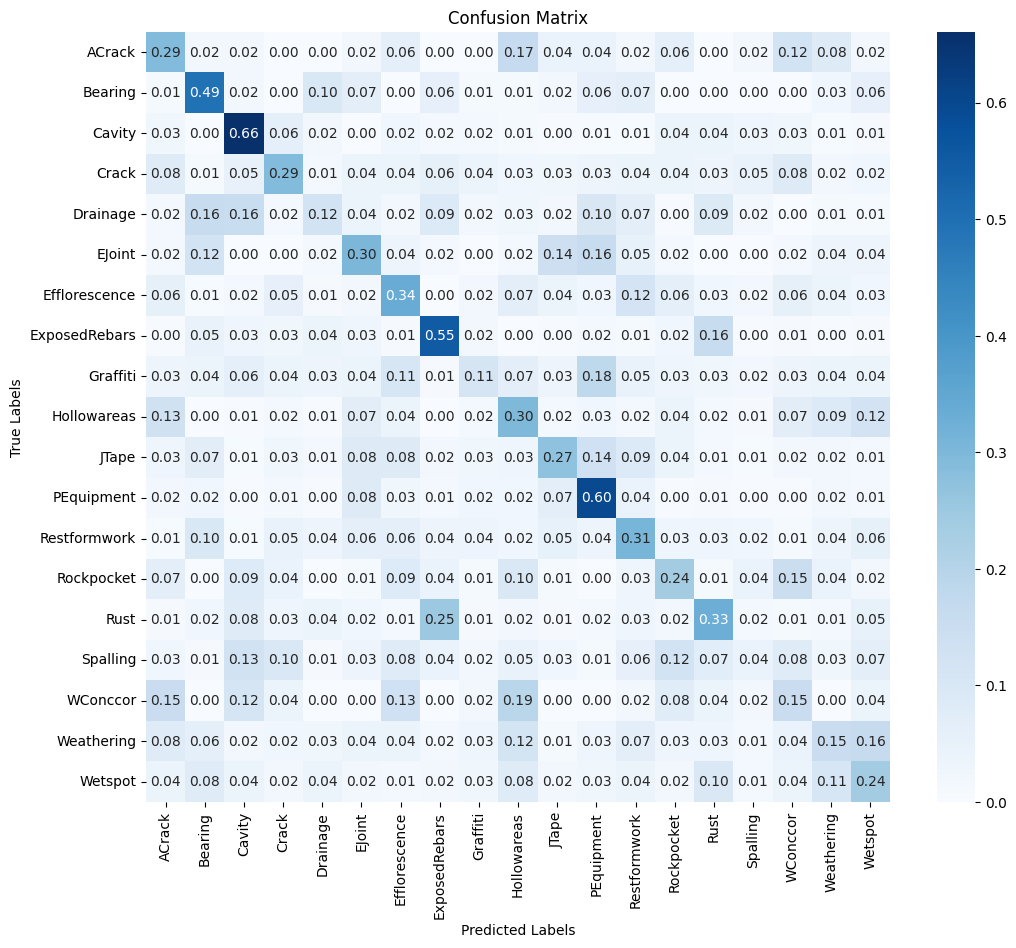

In [13]:
multilabel_classification = MultilabelClassificationModel("all").evaluate_results()
